# **Decision making in low-rank recurrent neural networks**
## Models of Higher Brain Function - Computer Course Project 
### *Sujitkumar Gavali & Luke Longren*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (12,6)

## 1. Understanding the paper


Discussion:

## 2. Go-No Go discrimination

In [3]:
"""Create the N-dimensional go and no-go patterns I_A, I_B and readout w"""
N = 1000  # dimension number
var = 4  # variance of Gaussian sampling
I_A = np.random.normal(loc=0, scale=np.sqrt(var), size=(N,1))  # go
I_B = np.random.normal(loc=0, scale=np.sqrt(var), size=(N,1))  # to not go
w = np.random.normal(loc=0, scale=np.sqrt(var), size=(N,1))  # the readout

In [4]:
"""Define the structured and random part of the connectivity matrix"""
g = 1.0
P = (w @ I_A.T) / N  # structured part
xi = np.random.normal(loc=0, scale=np.sqrt(g/N), size=(N,N))  # random part
J = (g * xi) + P
print(J.shape)

(1000, 1000)


In [366]:
"""Simulate the network dynamics using forward-Euler"""
def go_nogo(J, I_on, x0, dt, t_max):
  """
  input:
  J: full connectivity matrix (N, N)
  I_in: input pattern (N)
  x0: initial input currents ()
  dt: time step size ()
  t_max: total simulation time ()
  output:
  x: total input current over time (N, time_points)
  I: input pattern over time (N, time_points)
  """
  phi = lambda x: np.tanh(x)  # current-to-rate transfer function
  func = lambda x, I: -x + J @ phi(x) + np.squeeze(I)  # input current
  
  # initialize arrays
  time_points = int(t_max / dt)
  I = np.zeros((N, time_points))
  x = np.zeros((N, time_points))
  x[:,0] = x0 

  # zero current at the edges
  edge_point = time_points * 0.15  # no stimulus period
  for t in range(time_points-1):
    if t < edge_point or t > time_points - 2*edge_point:
      I[:,t] = 0
    else:
      I[:,t] = np.squeeze(I_on)
    
    # run forward-Euler
    x[:,t+1] = x[:,t] + dt * func(x[:,t], I[:,t])

  return x, I

In [6]:
x0 = 0
dt = 0.1
t_max = 30
activation_A, input_A = go_nogo(J, I_A, x0, dt, t_max)
activation_B, input_B = go_nogo(J, I_B, x0, dt, t_max)
print(activation_A.shape, activation_B.shape)

(1000, 300) (1000, 300)


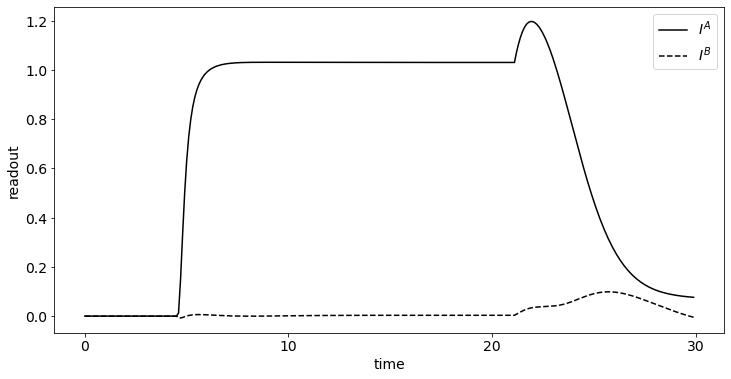

In [7]:
"""Determine the readout"""
readout_A = np.squeeze((w.T @ np.tanh(activation_A)) / N)
readout_B = np.squeeze((w.T @ np.tanh(activation_B)) / N)
plt.plot(readout_A, label='$I^A$', c='k', ls='-')
plt.plot(readout_B, label='$I^B$', c='k', ls='--')
plt.ylabel('readout')
plt.xlabel('time')
plt.xticks(np.linspace(0, t_max/dt, 4), 
           np.linspace(0, t_max, 4, dtype=int))
plt.legend()
plt.show()

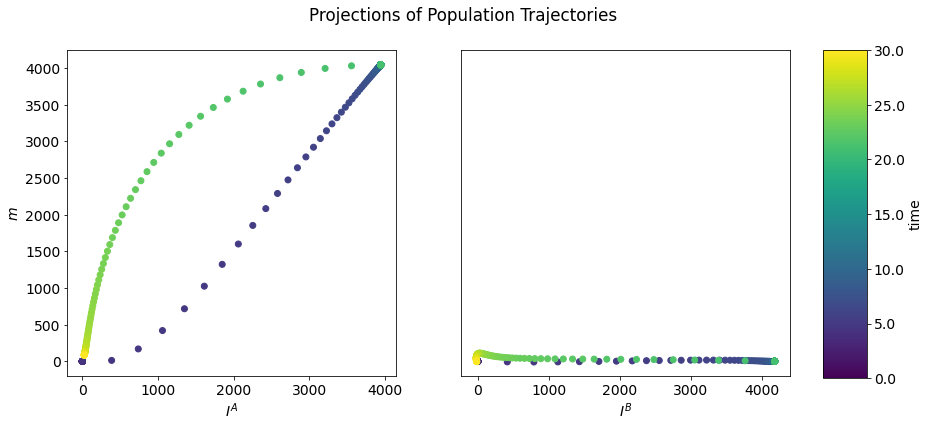

In [8]:
"""Project the input currents x onto the (m − I_A) and (m − I_B) plane"""
projected_input_A = [I_A.T @ activation_A, w.T @ activation_A]
projected_input_B = [I_B.T @ activation_B, w.T @ activation_B]

cmap = plt.cm.viridis(np.linspace(0, 1, int(t_max/dt)))
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1, 3, 1)
A = ax1.scatter(projected_input_A[0], projected_input_A[1], c=cmap)
ax1.set_ylabel('$m$')
ax1.set_xlabel('$I^A$')
ax2 = fig.add_subplot(1, 3, 2)
B = ax2.scatter(projected_input_B[0], projected_input_B[1], c=cmap)
ax2.set_xlabel('$I^B$')
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks([])
plt.suptitle('Projections of Population Trajectories', x=0.4)
cax = fig.add_subplot(1, 3, 3, position=[0.65,0.12,0.03,0.76])
fig.colorbar(A, cax=cax, ticks=np.linspace(0, 1, 7))
cax.set_yticklabels(np.linspace(0, t_max, 7))
cax.set_ylabel('time')
plt.show()

## 3. Evidence accumulation

In [9]:
"""Create the task"""
N = 2500  # network size
mu = 0  # sampling mean
sig = 1.2  # sampling std
I = np.random.normal(loc=mu, scale=sig, size=(N,1))  # input direction
w = np.random.normal(loc=mu, scale=sig, size=(N,1))  # the readout

rho = 2  
y = np.random.normal(loc=0, scale=1, size=(N,1))  # standard Gaussian vector
n = I + rho * y  # left connectivity vector
m = w + rho * y  # right connectivity vector

g = 0.8  # random strength
xi = np.random.normal(loc=0, scale=1/np.sqrt(N), size=(N,N))  # random part
J = g * xi + (m @ n.T) / N  # full connectivity matrix
print(J.shape)

(2500, 2500)


In [10]:
"""Setting up the RNN"""
def noisy_RNN(J, I_on, x0, dt, t_max, c_bar):
  """
  input:
  J: full connectivity matrix (N, N)
  I: input pattern (N)
  x0: initial input currents ()
  dt: time step size ()
  t_max: total simulation time ()
  c_bar: input strength sample mean ()
  output:
  x: total input current over time (N, time_points)
  I: input pattern over time (N, time_points)
  """
  # define the function
  ffun = lambda x: -x + J @ np.tanh(x)
  gfun = lambda x, I: np.random.normal(c_bar, np.sqrt(0.4)) * I.squeeze()

  # initialize arrays
  time_points = int(t_max / dt)
  x = np.zeros((N, time_points))
  x[:,0] = x0 

  # zero current at the beginning 
  I = np.zeros((N,time_points))
  edge_point = time_points * 0.2  # no stimulus period
  for t in range(time_points-1):
    if t < edge_point:
      I[:,t] = 0
    else:
      I[:,t] = I_on.squeeze()

  # run Euler-Maruyama
  for t in range(time_points-1):
    W = np.random.normal(loc=0, scale=np.sqrt(dt)) 
    x[:,t+1] = x[:,t] + (ffun(x[:,t]) * dt) + (gfun(x[:,t], I[:,t]) * np.sqrt(dt))# * W) 

  return x, I

In [111]:
"""Define the readout with a bias"""
def readout(x, w, b):
  """
  input:
  x: total input currents (N, time_points)
  w: input readout (N)
  b: bias ()
  output:
  z: readout (time_points)
  """
  return np.squeeze((w.T @ np.tanh(x)) / N) + b

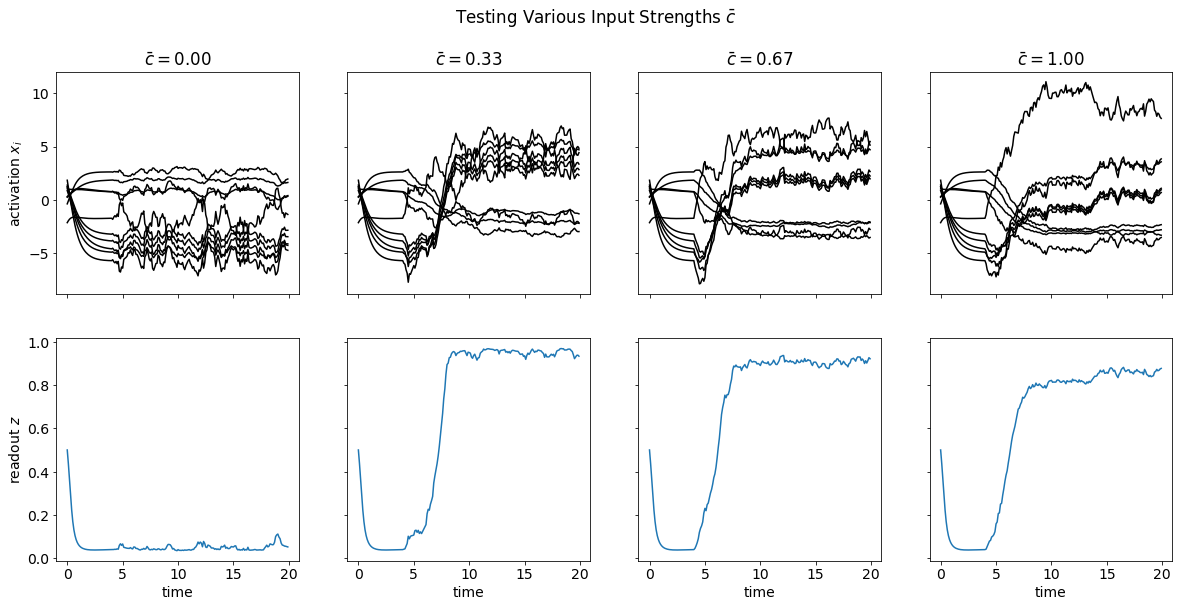

In [12]:
"""Visualize single-unit activity as well as the readout"""
#x0 = -2  # initial input current
x0 = np.squeeze(-I)  # avoid a response every simulation
#x0 = 0
b = 0.5  # bias, to keep output between 0 and 1
dt = 0.1  # step size
t_max = 20  # run for 200 time steps
test_num = 4  # number of c values to test

c_bars = np.linspace(0, 1, test_num)
fig, axs = plt.subplots(2, test_num, figsize=(20, 9), sharex=True, sharey='row')
for n in range(test_num):
  activity, _ = noisy_RNN(J, I, x0, dt, t_max, c_bars[n])
  z = readout(activity, w, b)
  activity_samples = np.linspace(0, activity.shape[0]-1, 10, dtype=int)
  [axs[0,n].plot(activity[i], c='k') for i in activity_samples]
  axs[0,n].set_title(r'$\bar{c} = %.2f$' %c_bars[n])
  axs[1,n].plot(z)
  axs[1,n].set_xlabel('time')

axs[0,0].set_ylabel('activation $x_i$')
axs[1,0].set_ylabel('readout $z$')
plt.suptitle(r'Testing Various Input Strengths $\bar{c}$')
plt.xticks(np.linspace(0, t_max/dt, 5), np.linspace(0, t_max, 5, dtype=int))
plt.show()

In [13]:
"""Create a psychometric curve"""
c_bars = np.linspace(0, 1, 11)  # chosen input strengths
resp_num = np.zeros(c_bars.size)  # response number
rand_num = np.zeros(c_bars.size)  # random number
sim_num = 5  # simulation number
for i in range(c_bars.size):  # loop over input strengths
  for _ in range(sim_num):  # loop over simulations
    # new randomness each simulation
    n = I + rho * y  # left connectivity vector
    m = w + rho * y  # right connectivity vector
    g = 0.8  # random strength
    xi = np.random.normal(loc=0, scale=1/np.sqrt(N), size=(N,N))  # random part
    J = g * xi + (m @ n.T) / N  # full connectivity matrix

    activity, _ = noisy_RNN(J, I, x0, dt, t_max, c_bars[i])
    z = readout(activity, w, b)
    if z[-1] > 0.5:
      resp_num[i] += 1
    if z[np.random.choice(z.size)] > 0.5:
      rand_num[i] += 1

[0. 0. 1. 5. 5. 5. 5. 5. 5. 5. 5.] , generated response number
[0. 0. 1. 1. 3. 3. 4. 4. 3. 3. 4.] , random selection number


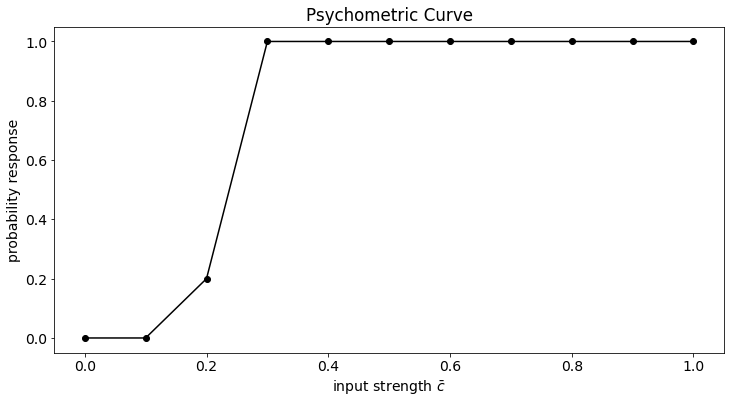

In [14]:
print(resp_num, ', generated response number')
print(rand_num, ', random selection number')
plt.plot(c_bars, resp_num/sim_num, marker='o', c='k')
plt.ylabel('probability response')
plt.xlabel(r'input strength $\bar{c}$')
plt.title('Psychometric Curve')
plt.show()

In [15]:
"""Collect the data for linear regression"""
trial_num = len(c_bars) * sim_num  # number of trials
F = np.zeros((2, trial_num))  # predictor matrix
X_T = np.zeros((trial_num, N))  # final network states
count = -1
for n in range(len(c_bars)):
  for _ in range(sim_num):
    count += 1
    # run the simulation
    activity, _ = noisy_RNN(J, I, x0, dt, t_max, c_bars[n])
    z = readout(activity, w, b)
    # collect the stimulus values
    F[0,count] = c_bars[n]
    F[1,count] = z[-1]
    # collect the final network states
    X_T[count] = activity[:,-1]

From the equation for linear regression:  
## $x_i(k) = \beta^{input}_i \bar{c}(k) + \beta^{choice}_i z(k)$   

In [16]:
"""Use linear regression to fit the encoding model"""
def linear_regression(F, X_T):
  # least squares inversion
  ls = np.linalg.inv(F @ F.T) @ F
  beta_choice, beta_input = ls.dot(X_T)
  return beta_choice, beta_input

beta_choice, beta_input = linear_regression(F, X_T)
print(beta_input.shape, beta_choice.shape)

(2500,) (2500,)


In [17]:
"""Find the coefficient of determination"""
def coeff_determ(c_bar, z, x, beta_i, beta_c):
  x_func = lambda beta_i, beta_c: beta_i * c_bar + beta_c * z
  res = np.sum((x - x_func(beta_i, beta_c))**2) # residual sum of squares
  tot = np.sum((x - x.sum())**2) # total sum of squares
  return 1 - (res/tot)

r_2 = 0
for i in range(N):
  r_2 += coeff_determ(F[0], F[1], X_T[:,i], beta_input[i], beta_choice[i]) / N
print('R^2: {:.3f}'.format(r_2))

R^2: 0.980


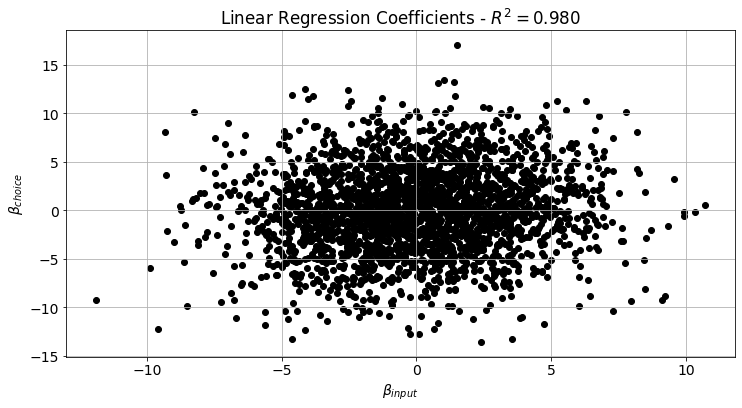

In [18]:
"""Check that most of the neurons are mixed selective"""
plt.scatter(beta_input, beta_choice, c='k')
plt.xlabel(r'$\beta_{input}$')
plt.ylabel(r'$\beta_{choice}$')
plt.title('Linear Regression Coefficients - $R^2={:.3f}$'.format(r_2))
plt.grid()
plt.show()

In [19]:
"""Collect the data for PCA"""
time_num = int(t_max/dt)
X = np.zeros((N, trial_num, time_num))  # population activity
count = -1
for n in range(len(c_bars)):
  for _ in range(sim_num):
    count += 1
    # run the simulation
    activity, _ = noisy_RNN(J, I, x0, dt, t_max, c_bars[n])
    # collect the population activity
    X[:,count,:] = activity

# reshape the data
X_flat = X.reshape((N, trial_num * time_num))
print(X_flat.shape)

(2500, 11000)


In [20]:
"""Perform dimensionality reduction using PCA"""
def PCA(data):
    cov = np.cov(data, rowvar=True)  # measure covariances, construct the matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)  # eigenvalue decomposition
    return cov, eigenvalues, eigenvectors

cov, eigenvalues, eigenvectors = PCA(X_flat)
print(cov.shape, eigenvalues.shape, eigenvectors.shape)

(2500, 2500) (2500,) (2500, 2500)


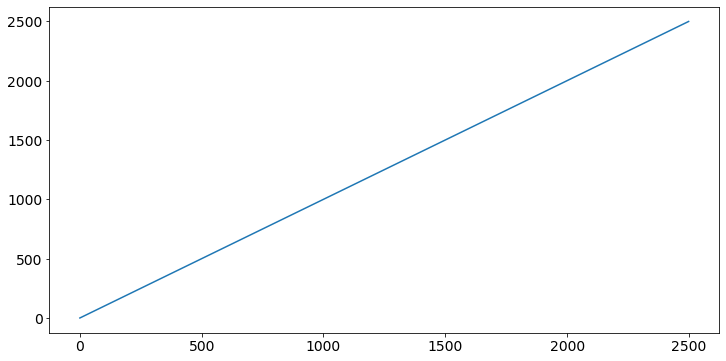

In [21]:
plt.plot(np.argsort(eigenvalues))

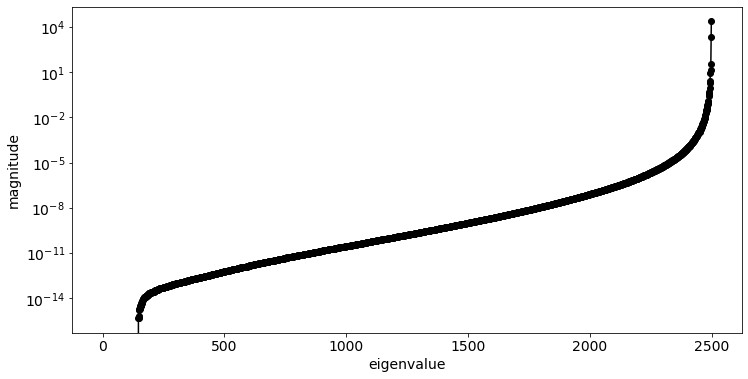

In [22]:
plt.plot(eigenvalues, marker='o', c='k')
plt.xlabel('eigenvalue')
plt.ylabel('magnitude')
plt.yscale('log')
plt.show()

(2500,) (2500,)


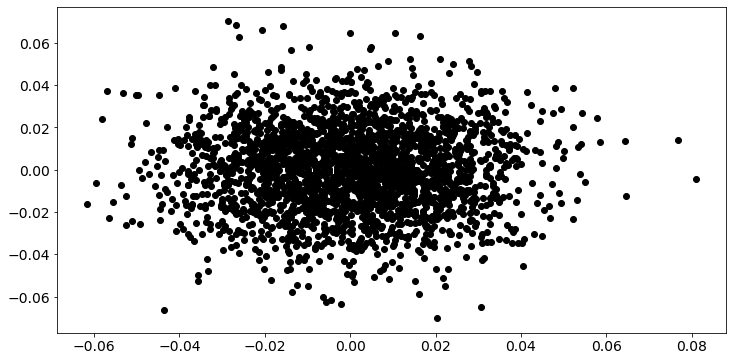

In [23]:
PC1 = eigenvectors[:,-1]
PC2 = eigenvectors[:,-2]
print(PC1.shape, PC2.shape)
plt.scatter(PC1, PC2, c='k')
plt.show()

## 4.  Context-dependent evidence accumulation

In [24]:
"""Create the more complicated decision making task"""
def context_dependent(N, w, cbar_A, cbar_B, x0, t_max, dt, rel_stim):
  """
  input:
  N: size of the network ()
  w: the readout (N)
  cbar_A: stimulus A strength ()
  cbar_B: stimulus B strength ()
  time_points: length of the simulation ()
  rel_stim: relevant stimulus, str(I_A/I_B)
  output:
  x: total input current over time (N, time_points)
  I: input pattern over time (N, time_points)
  """
  time_points = int(t_max/dt)
  mu = 0  # sample mean
  sigma = 1.2  # sample std

  # input directions
  I_A = np.random.normal(loc=mu, scale=sigma, size=N)
  I_B = np.random.normal(loc=mu, scale=sigma, size=N)
  # contextual signals
  I_ctxA = np.random.normal(loc=mu, scale=sigma, size=(time_points, N))
  I_ctxB = np.random.normal(loc=mu, scale=sigma, size=(time_points, N))
  # time-varying stimuli
  c_A = np.random.normal(loc=cbar_A, scale=0.3, size=(time_points, N))
  c_B = np.random.normal(loc=cbar_B, scale=0.3, size=(time_points, N))
  # contextual components
  if rel_stim == 'I_A':
    gamma_A, gamma_B = 0.1, -0.4
  elif rel_stim == 'I_B':
    gamma_A, gamma_B = -0.4, 0.1
  # overlap components
  y_A = np.random.normal(loc=0, scale=1)
  y_B = np.random.normal(loc=0, scale=1)
  # the scalar parameters
  rho_m = 3
  rho_n = 1.5
  beta_m = 0.6
  beta_n = 1
  # left and right connectivity vectors
  m_1 = y_A + rho_m * I_ctxA + beta_m * w
  n_1 = I_A + rho_n * I_ctxA + beta_n * w
  m_2 = y_B + rho_m * I_ctxB + beta_m * w
  n_2 = I_B + rho_n * I_ctxB + beta_n * w
  # external input to the network
  I_on = c_A @ I_A + c_B @ I_B + gamma_A * I_ctxA.T + gamma_B * I_ctxB.T

  # zero current at the beginning 
  I = np.zeros(time_points)
  edge_point = time_points * 0.2  # no stimulus period
  for t in range(time_points-1):
    if t < edge_point:
      I[t] = 0
    else:
      I[t] = I_on.mean(axis=0)[t]
  # define the connectivity matrix and function to integrate
  g = 2  # random part strength
  xi = np.random.normal(loc=0, scale=1/np.sqrt(N), size=(N,N))  # random part
  J = g * xi + (m_1.T @ n_1 / N) + (m_2.T @ n_2 / N) 
  ffun = lambda x: -x + J @ np.tanh(x)
  gfun = lambda I: I

  # run Euler-Maruyama
  x = np.zeros((N, time_points))
  x[:,0] = x0 
  for t in range(time_points-1):
    W = np.random.normal(loc=0, scale=np.sqrt(dt)) 
    x[:,t+1] = x[:,t] + (ffun(x[:,t]) * dt) + (gfun(I[t]) * np.sqrt(dt))# * W) 

  return x, I

In [25]:
"""Create a psychometric curve"""
cbar_A = np.linspace(0, 1, 11)
cbar_B = np.zeros(11)
resp_num1 = np.zeros(cbar_A.size)  # response number for A relevance
resp_num2 = np.zeros(cbar_A.size)  # response number for B relevance
sim_num = 5  # simulation number
for i in range(c_bars.size):  # loop over input strengths
  for _ in range(sim_num):  # loop over simulations
    t_max = 30
    dt = 0.1
    x0 = 0
    N = 5000  # size of the network
    w = np.random.normal(loc=0, scale=1.2, size=N)
    b = 0.5

    activity1, _ = context_dependent(N, w, cbar_A[i], cbar_B[i], x0, t_max, dt, 'I_A')
    z1 = readout(activity1, w, b)
    if z1[-1] > 0.5:
      resp_num1[i] += 1

    activity2, _ = context_dependent(N, w, cbar_A[i], cbar_B[i], x0, t_max, dt, 'I_B')
    z2 = readout(activity2, w, b)
    if z2[-1] > 0.5:
      resp_num2[i] += 1

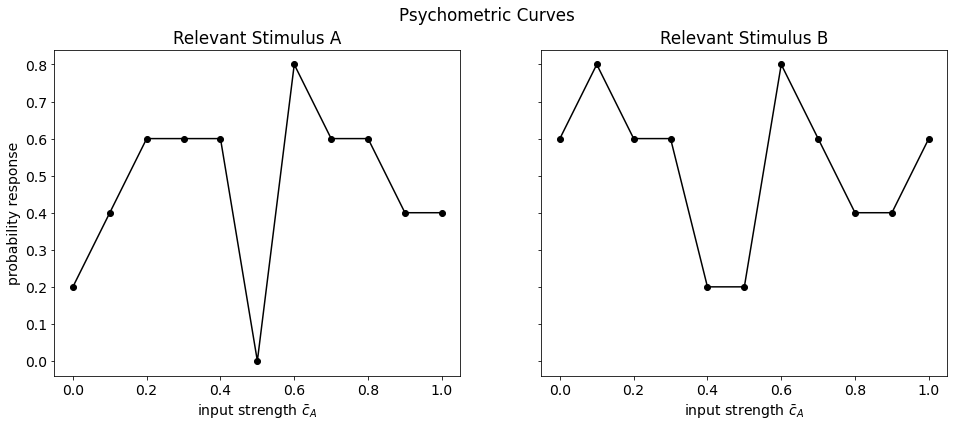

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey=True)
ax1.plot(cbar_A, resp_num1/sim_num, marker='o', c='k')
ax1.set_ylabel('')
ax1.set_title('Relevant Stimulus A')
ax1.set_ylabel('probability response')
ax1.set_xlabel(r'input strength $\bar{c}_A$')
ax2.plot(cbar_A, resp_num2/sim_num, marker='o', c='k')
ax2.set_title('Relevant Stimulus B')
ax2.set_xlabel(r'input strength $\bar{c}_A$')
plt.suptitle('Psychometric Curves')
plt.show()

## 5. Training RNNs

In [6]:
import torch  # will be using PyTorch
import matplotlib.pyplot as plt
import numpy as np

In [421]:
"""Create an RNN using PyTorch using tanh non-linearity"""
N = 500  # network size
# the learnable parameters
m_1 = np.random.normal(loc=0, scale=1, size=(N,1))
n_1 = np.random.normal(loc=0, scale=1, size=(N,1))
# the recurrent weight matrix
J = m_1 @ n_1.T / np.sqrt(N)
# the readout and input pattern
w = np.random.normal(loc=0, scale=np.sqrt(1.2), size=(N,1))
I = np.random.normal(loc=0, scale=np.sqrt(1.2), size=(N,1))

In [422]:
# initialize the RNN
rnn = torch.nn.RNN(input_size=N, hidden_size=N, nonlinearity='tanh')

# make tensors
m_n_tensor = torch.tensor([m_1, n_1])
# apply the learnable parameters
#rnn.weight_ih_l = torch.nn.Parameter(m_n_tensor)
rnn.weights = torch.nn.Parameter(m_n_tensor)
# setup input and hidden state for the network
input = torch.tensor([I.T, w.T]).float()
h0 = torch.zeros(1, 1, N)

# run the network
output, hn = rnn(input, h0)

In [423]:
print(output.shape)
print(hn.shape)
print(optimizer)
for param in rnn.parameters():
    print(type(param.data), param.size())

torch.Size([2, 1, 500])
torch.Size([1, 1, 500])
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
<class 'torch.Tensor'> torch.Size([500, 500])
<class 'torch.Tensor'> torch.Size([500, 500])
<class 'torch.Tensor'> torch.Size([500])
<class 'torch.Tensor'> torch.Size([500])
<class 'torch.Tensor'> torch.Size([2, 500, 1])


In [424]:
# optimize the network using Adam
def MSE(output):
  x, w = output.detach().numpy()
  x, w = x[0], w[0]
  cbar = np.random.uniform(0, 1)
  c = np.random.normal(cbar, 0.4)
  z = readout(x, w, 0.5)  
  # optimal choice
  if z > 0.5:
    y = 1
  else:
    y = 0
  # mean squared error
  MSE = np.mean((y - z)**2)
  return torch.tensor(MSE, requires_grad=True)
  
eta = 1e-3
optimizer = torch.optim.Adam(rnn.parameters(), lr=eta)

count = 0
for _ in range(1000):
  for _ in range(64):
    optimizer.zero_grad()
    x, w = output.detach().numpy()
    input = torch.tensor([x, w]).float()
    output, hn = rnn(input, h0)
    loss = MSE(output)
    loss.backward()
    optimizer.step() 

  z = readout(x.T, w.T, b=0.5)
  if z > 0.5:
    count += 1
print(count)

1000


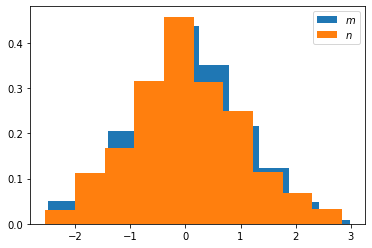

In [438]:
plt.hist(rnn.weights.detach().numpy()[0], histtype='bar', label='$m$', density=True)
plt.hist(rnn.weights.detach().numpy()[1], histtype='bar', label='$n$', density=True)
plt.legend()
plt.show()

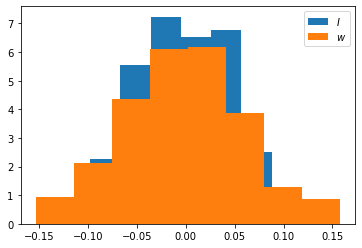

In [437]:
plt.hist(output.detach()[0], bins=8, histtype='bar', label='$I$', density=True)
plt.hist(output.detach()[1], bins=8, histtype='bar', label='$w$', density=True)
plt.legend()
plt.show()
# plt.hist(hn.detach().squeeze(), bins=8, histtype='bar', density=True)
# plt.show()

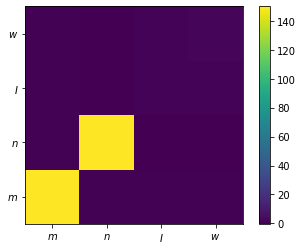

In [415]:
"""Train 10 networks with different random initializations"""
scalar_products = np.zeros((4,4))
net_num = 10

for _ in range(net_num):
  N = 500  # network size
  # the learnable parameters
  m_1 = np.random.normal(loc=0, scale=1, size=(N,1))
  n_1 = np.random.normal(loc=0, scale=1, size=(N,1))
  # the recurrent weight matrix
  J = m_1 @ n_1.T / np.sqrt(N)
  # the readout and input pattern
  w = np.random.normal(loc=0, scale=np.sqrt(1.2), size=(N,1))
  I = np.random.normal(loc=0, scale=np.sqrt(1.2), size=(N,1))

  # initialize the RNN
  rnn = torch.nn.RNN(input_size=N, hidden_size=N, nonlinearity='tanh')
  # make tensors
  m_n_tensor = torch.tensor([m_1, n_1])
  # apply the learnable parameters
  #rnn.weight_ih_l = torch.nn.Parameter(m_n_tensor)
  rnn.weights = torch.nn.Parameter(m_n_tensor)
  # setup input and hidden state for the network
  input = torch.tensor([I.T, w.T]).float()
  h0 = torch.zeros(1, 1, N)
  # run the network
  output, hn = rnn(input, h0)

  trial_num = 64
  eta = 1e-3
  optimizer = torch.optim.Adam(rnn.parameters(), lr=eta)
  for _ in range(trial_num):
    optimizer.zero_grad()
    x, w = output.detach().numpy()
    input = torch.tensor([x, w]).float()
    output, hn = rnn(input, h0)
    loss = MSE(output)
    loss.backward()
    optimizer.step() 

  m = rnn.weights[0].detach().numpy()
  n = rnn.weights[1].detach().numpy()
  one_side = np.array([m, n, x.T, w.T]).squeeze()
  #print((one_side @ one_side.T).shape)
  scalar_products += one_side @ one_side.T

avg_products = scalar_products / net_num
label = ['$m$', '$n$', '$I$', '$w$']
label_old = np.linspace(0, 3, 4)
plt.imshow(avg_products, aspect='equal', origin='lower', vmax=150)
plt.xticks(label_old, label)
plt.yticks(label_old, label)
plt.colorbar()
plt.show()

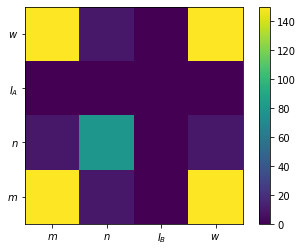

In [409]:
# same as for exercise one
scalar_products2 = np.zeros((4,4))

for _ in range(net_num):
  N = 1000  # dimension number
  var = 4  # variance of Gaussian sampling
  I_A = np.random.normal(loc=0, scale=np.sqrt(var), size=(N,1))  # go
  I_B = np.random.normal(loc=0, scale=np.sqrt(var), size=(N,1))  # to not go
  w = np.random.normal(loc=0, scale=np.sqrt(var), size=(N,1))  # the readout
  g = 1.0
  P = (w @ I_A.T) / N  # structured part
  xi = np.random.normal(loc=0, scale=np.sqrt(g/N), size=(N,N))  # random part
  J = (g * xi) + P

  x0 = 0
  dt = 0.1
  t_max = 30
  activation_A, input_A = go_nogo(J, I_A, x0, dt, t_max)
  activation_B, input_B = go_nogo(J, I_B, x0, dt, t_max)

  m = w.squeeze()
  n = activation_A[:,-1].squeeze()
  I_A = input_A[:,-1].squeeze()
  I_B = input_B[:,-1].squeeze()
  w = w.squeeze()

  one_side = np.array([m, n, I_A, w])
  other_side = np.array([m, n, I_B, w])
  scalar_products2 += one_side @ other_side.T

avg_products = scalar_products2 / net_num
label_A = ['$m$', '$n$', '$I_A$', '$w$']
label_B = ['$m$', '$n$', '$I_B$', '$w$']
label_old = np.linspace(0, 3, 4)
plt.imshow(avg_products, aspect='equal', origin='lower', vmax=150)
plt.xticks(label_old, label_B)
plt.yticks(label_old, label_A)
plt.colorbar()
plt.show()